# Importing Libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)


        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [6]:
results

mediapipe.python.solution_base.SolutionOutputs

In [7]:
draw_landmarks(frame, results)

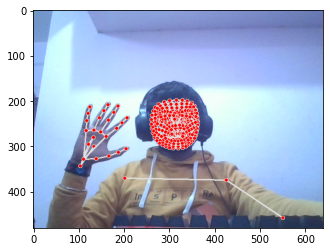

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [9]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [10]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [12]:
result_test = extract_keypoints(results)

In [13]:
result_test

array([ 0.49119249,  0.52923858, -0.92133838, ...,  0.19684789,
        0.44552949, -0.04196727])

In [14]:
468*3+33*4+21*3+21*3

1662

In [15]:
np.save('0', result_test)

In [16]:
np.load('0.npy')

array([ 0.49119249,  0.52923858, -0.92133838, ...,  0.19684789,
        0.44552949, -0.04196727])

# Setup Folders for Collection

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'sorry', 'help', 'home'])

# Thirty videos of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [18]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [330]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break 
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [331]:
cap.release()
cv2.destroyAllWindows()

#  Preprocess Data and Create Labels and Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num, label in enumerate(actions)}

In [21]:
label_map

{'hello': 0, 'thanks': 1, 'sorry': 2, 'help': 3, 'home': 4}

In [22]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [23]:
np.array(sequences).shape

(150, 30, 1662)

In [24]:
np.array(labels).shape

(150,)

In [25]:
X = np.array(sequences)

In [26]:
X.shape

(150, 30, 1662)

In [27]:
y = to_categorical(labels).astype(int)

In [28]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0,

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [32]:
y_test.shape

(8, 5)

# Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
model = Sequential()
model.add(LSTM(32, name='lstm1', return_sequences=False, activation='relu', input_shape=(30,1662)))
#model.add(LSTM(128,name='lstm2', return_sequences=True, activation='relu'))
#model.add(LSTM(64, name='lstm3', return_sequences=False, activation='relu'))
#model.add(Dense(64, name='dense1', activation='relu'))
#model.add(Dense(32, name= 'dense2', activation='relu'))
model.add(Dense(actions.shape[0], name='dense3', activation='softmax'))

In [36]:
res = [.7, 0.2, 0.1,0.3,0.8]

In [37]:
actions[np.argmax(res)]

'home'

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit(X_train, y_train, epochs=25, callbacks=[tb_callback],validation_split=0.1)

Epoch 1/25
4/4 [==============================] - 0s 89ms/step - loss: 0.0489 - accuracy: 0.9843 - val_loss: 1.1245 - val_accuracy: 0.7333
Epoch 2/25
4/4 [==============================] - 0s 51ms/step - loss: 0.0711 - accuracy: 0.9764 - val_loss: 0.6023 - val_accuracy: 0.8667
Epoch 3/25
4/4 [==============================] - 0s 52ms/step - loss: 0.0329 - accuracy: 0.9921 - val_loss: 0.4733 - val_accuracy: 0.8667
Epoch 4/25
4/4 [==============================] - 0s 51ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.9333
Epoch 5/25
4/4 [==============================] - 0s 50ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.5452 - val_accuracy: 0.8667
Epoch 6/25
4/4 [==============================] - 0s 60ms/step - loss: 0.0356 - accuracy: 0.9843 - val_loss: 0.6172 - val_accuracy: 0.8667
Epoch 7/25
4/4 [==============================] - 0s 53ms/step - loss: 0.0873 - accuracy: 0.9606 - val_loss: 2.9086 - val_accuracy: 0.6000
Epoch 8/25
4/4 [===========

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 32)                216960    
_________________________________________________________________
dense3 (Dense)               (None, 5)                 165       
Total params: 217,125
Trainable params: 217,125
Non-trainable params: 0
_________________________________________________________________


# Make Predictions

In [97]:
res = model.predict(X_test)

In [98]:
actions[np.argmax(res[4])]

'home'

In [96]:
actions[np.argmax(y_test[4])]

'home'

# Save Weights

In [99]:
model.save('action.h5')

In [100]:
model.load_weights('action.h5')

# Evaluation using Accuracy

In [101]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [102]:
yhat = model.predict(X_test)

In [103]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [104]:
accuracy_score(ytrue, yhat)

1.0

# Test in Real Time

In [111]:
colors = [(245,117,16), (117,245,16), (16,117,245),(102, 204, 255),(255,102,153)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [120]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (255, 205, 81), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sorry
<class 'mediapipe.python.solution_base.SolutionOutputs'